In [1]:
import os
import shutil
import random
# Set the seed for reproducibility
random.seed(42)

# Prep dataset

In [ ]:
data_path = 'dataset/caltech.zip'

if os.path.isfile(data_path):
  print('Dataset zip already exists')
else:
  print('Downloading N-Caltech101 dataset...')
  !mkdir dataset
  !cd dataset && wget -O caltech.zip https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/cy6cvx3ryv-1.zip

In [ ]:
### Go to `dataset` folder
%cd dataset/

In [ ]:
### Unzip main zip
!unzip caltech.zip

In [ ]:
### Unzip the actual dataset Caltech101:
!unzip cy6cvx3ryv-1/Caltech101.zip

In [ ]:
### Unzip the annotations of Caltech101:
!unzip cy6cvx3ryv-1/Caltech101_annotations.zip

In [22]:
### Make the new ncaltech101 main directory
import os
import shutil
import random
# Set the seed for reproducibility
random.seed(42)

!rm -rf ncaltech101

original_dir = 'Caltech101'
new_dir = 'ncaltech101'

if os.path.exists(new_dir):
    print('The directory `ncaltech101` already exists. Please delete it and try again.')
else:
  os.mkdir(new_dir)

In [23]:
### Make the train, validation, test, raw, annotations directories.
train_dir = os.path.join(new_dir, 'training')
val_dir = os.path.join(new_dir, 'validation')
test_dir = os.path.join(new_dir, 'test')
raw_dir = os.path.join(new_dir, 'raw')
ann_dir = os.path.join(new_dir, 'annotations')

os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)
os.mkdir(raw_dir)
os.mkdir(ann_dir)

In [24]:
### Copy annotations into ncaltech101/annotations dir.
!cp -a 'Caltech101_annotations/.' 'ncaltech101/annotations'

In [25]:
### Make a directory for each class in the train, validation, test and raw directories.
### At the same time, get the number of images in each class.
class_counts = {}

class_folders = os.listdir(original_dir) # [:3]

for class_dir in class_folders:
    os.mkdir(os.path.join(train_dir, class_dir))
    os.mkdir(os.path.join(val_dir, class_dir))
    os.mkdir(os.path.join(test_dir, class_dir))
    os.mkdir(os.path.join(raw_dir, class_dir))

    class_counts[class_dir] = len(os.listdir(os.path.join(original_dir, class_dir)))

print (class_counts)

{'crocodile': 50, 'lotus': 66, 'menorah': 87, 'water_lilly': 37, 'chair': 62, 'stop_sign': 64, 'okapi': 39, 'flamingo_head': 45, 'panda': 38, 'dollar_bill': 52, 'yin_yang': 60, 'revolver': 82, 'ibis': 80, 'starfish': 86, 'cellphone': 59, 'Faces_easy': 435, 'hawksbill': 100, 'minaret': 76, 'crocodile_head': 51, 'car_side': 123, 'elephant': 64, 'cup': 57, 'ceiling_fan': 47, 'dalmatian': 67, 'butterfly': 91, 'chandelier': 107, 'anchor': 42, 'ewer': 85, 'pagoda': 47, 'crayfish': 70, 'ant': 42, 'octopus': 35, 'wheelchair': 59, 'emu': 53, 'brain': 98, 'trilobite': 86, 'joshua_tree': 64, 'sea_horse': 57, 'dolphin': 65, 'gramophone': 51, 'kangaroo': 86, 'windsor_chair': 56, 'gerenuk': 34, 'inline_skate': 31, 'wrench': 39, 'scorpion': 84, 'bass': 54, 'camera': 50, 'snoopy': 35, 'schooner': 63, 'beaver': 46, 'scissors': 39, 'barrel': 47, 'umbrella': 75, 'crab': 73, 'headphone': 42, 'cougar_body': 47, 'platypus': 34, 'pigeon': 45, 'hedgehog': 54, 'wild_cat': 34, 'euphonium': 64, 'saxophone': 40, 

In [26]:
### Copy the data into the train, validation and test directories (80%, 10%, 10%)
for class_dir in class_folders:
    images = os.listdir(os.path.join(original_dir, class_dir))
    random.shuffle(images)

    train_images = images[:int(0.8 * class_counts[class_dir])]
    val_images = images[int(0.8 * class_counts[class_dir]):int(0.9 * class_counts[class_dir])]
    test_images = images[int(0.9 * class_counts[class_dir]):]

    for image in train_images:
        shutil.copyfile(os.path.join(original_dir, class_dir, image), os.path.join(train_dir, class_dir, image))

    for image in val_images:
        shutil.copyfile(os.path.join(original_dir, class_dir, image), os.path.join(val_dir, class_dir, image))

    for image in test_images:
        shutil.copyfile(os.path.join(original_dir, class_dir, image), os.path.join(test_dir, class_dir, image))

In [27]:
### Check that the data has been split correctly
for split in [train_dir, val_dir, test_dir]:
    total = 0
    for class_dir in os.listdir(split):
        total += len(os.listdir(os.path.join(split, class_dir)))
    print(split, total)

ncaltech101/training 6559
ncaltech101/validation 816
ncaltech101/test 867


In [ ]:
%cd ..

In [ ]:
%ls dataset/ncaltech101

# Pre-processing

In [2]:
!pip install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/alexmano/aegnn
  Running setup.py develop for aegnn


In [28]:
! CUDA_VISIBLE_DEVICES=0 python scripts/preprocessing.py --dataset ncaltech101 --num-workers 0

Global seed set to 12345
 42%|████████████████▏                      | 2727/6559 [01:52<04:28, 14.27it/s]

In [ ]:
! python scripts/train.py graph_res --task recognition --dataset ncaltech101 --gpu 0 --batch-size 8 --dim 3 --num-workers 0

In [ ]:
! CUDA_VISIBLE_DEVICES=0 python evaluation/flops.py --device cuda

# Evaluate

In [18]:
path = "logs/checkpoints/ncaltech101/recognition/20230403001248/epoch=1-step=19.pt"
! python evaluation/accuracy_per_events.py logs/checkpoints/ncaltech101/recognition/20230403001248/epoch=1-step=19.pt --dataset ncaltech101 --device cuda

  0%|                                                    | 0/45 [00:00<?, ?it/s]/opt/conda/envs/aegnn/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/envs/aegnn/lib/python3.8/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
evaluation/accuracy_per_events.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

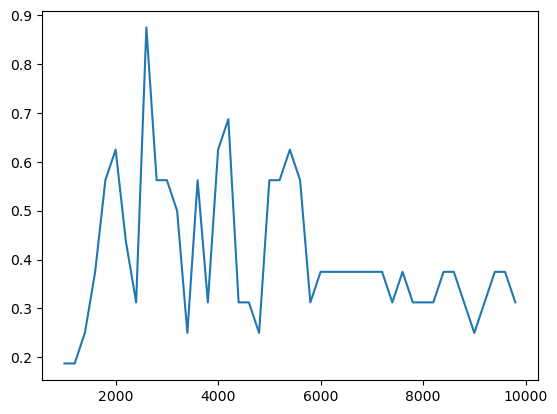

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_pickle("../aegnn_results/accuracy_per_events.pkl")
plt.plot(df['max_num_events'], df['accuracy'])